<a href="https://colab.research.google.com/github/drrao01/gpr2_v01/blob/main/AFM_423_GPR2_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO (Mark things as completed when done): 

1.   Load in data [COMPLETED]
2.   Data Preprocessing (Merge all data sets, remove days with low volume, make graphs/data viz. regarding price, moneyness, profitability, and volume trends, convert time-to-maturity to hours) [COMPLETED - OUTSTANDING: Data visualization]
3.   Apply Black Scholes Model
4.   Apply simple NN (with factor data and without factor data)
5.   Apply gated NN (with factor data and without factor data)
6.   Create results summary (training times, accuracy, MSE, MAPE, graph of predicted price vs actual price)





In [1]:
!pip install yfinance
!pip install yahoofinancials

In [2]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib
import seaborn
import sklearn 
import datetime as dt
from scipy.stats import norm
import math
import yfinance as yf

In [3]:
url = 'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_201812.txt'
df = pd.read_csv(url, sep=",", low_memory=False)
df = df.drop(columns=[' [P_BID]', ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]'])
print(df.shape)

(119298, 22)


In [4]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,10 x 10,1178.000000,1201.500000,1600.0,1190.5,0.427
1,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 12,1078.010000,1101.610000,1700.0,1090.5,0.391
2,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 13,1028.000000,1051.610000,1750.0,1040.5,0.373
3,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 1,978.000000,1001.500000,1800.0,990.5,0.355
4,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,10 x 11,928.000000,951.600000,1850.0,940.5,0.337


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119298 entries, 0 to 119297
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   [QUOTE_UNIXTIME]        119298 non-null  int64  
 1    [QUOTE_READTIME]       119298 non-null  object 
 2    [QUOTE_DATE]           119298 non-null  object 
 3    [QUOTE_TIME_HOURS]     119298 non-null  float64
 4    [UNDERLYING_LAST]      119298 non-null  float64
 5    [EXPIRE_DATE]          119298 non-null  object 
 6    [EXPIRE_UNIX]          119298 non-null  int64  
 7    [DTE]                  119298 non-null  float64
 8    [C_DELTA]              119298 non-null  object 
 9    [C_GAMMA]              119298 non-null  object 
 10   [C_VEGA]               119298 non-null  object 
 11   [C_THETA]              119298 non-null  object 
 12   [C_RHO]                119298 non-null  object 
 13   [C_IV]                 119298 non-null  object 
 14   [C_VOLUME]         

In [6]:
years = list(range(19, 22))
months = list(range(1, 13))

for year in years: 
  for month in months: 
    #print(f'{year} - {month}:')
    if month < 10:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}0{month}.txt'
    else:
      url = f'https://raw.githubusercontent.com/drrao01/gpr2_v01/main/Data/spx_eod_20{year}{month}.txt'
    df_temp = pd.read_csv(url)
    df_temp = df_temp.drop(columns=[' [P_BID]', ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]'])
    print(f'{year} - {month}: {df_temp.shape}')
    df = df.append(df_temp)

print(df.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18,20,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


19 - 1: (128066, 22)
19 - 2: (109343, 22)
19 - 3: (110807, 22)
19 - 4: (117842, 22)
19 - 5: (116178, 22)
19 - 6: (112336, 22)
19 - 7: (128786, 22)
19 - 8: (126689, 22)
19 - 9: (106921, 22)
19 - 10: (132203, 22)
19 - 11: (125946, 22)
19 - 12: (137145, 22)
20 - 1: (141027, 22)
20 - 2: (132836, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


20 - 3: (182489, 22)
20 - 4: (149674, 22)
20 - 5: (122921, 22)
20 - 6: (140718, 22)
20 - 7: (144085, 22)
20 - 8: (138634, 22)
20 - 9: (154709, 22)
20 - 10: (150346, 22)
20 - 11: (129871, 22)
20 - 12: (149467, 22)
21 - 1: (143231, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


21 - 2: (138022, 22)
21 - 3: (179050, 22)
21 - 4: (175555, 22)
21 - 5: (159887, 22)
21 - 6: (173394, 22)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


21 - 7: (178901, 22)
21 - 8: (179878, 22)
21 - 9: (162052, 22)
21 - 10: (191477, 22)
21 - 11: (199887, 22)
21 - 12: (209661, 22)
(5399332, 22)


In [7]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_RHO],[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,10 x 10,1178.000000,1201.500000,1600.0,1190.5,0.427
1,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 12,1078.010000,1101.610000,1700.0,1090.5,0.391
2,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 13,1028.000000,1051.610000,1750.0,1040.5,0.373
3,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,20 x 1,978.000000,1001.500000,1800.0,990.5,0.355
4,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2018-12-03,1543870800,0.0,1.000000,0.000000,...,0.000000,,,0.000000,10 x 11,928.000000,951.600000,1850.0,940.5,0.337


In [8]:
print(df.columns)

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [STRIKE_DISTANCE]',
       ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')


In [9]:
df_processed = df[df[' [DTE]'] >= 48]
df_processed.shape

(2648547, 22)

In [10]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2648547 entries, 3519 to 209660
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   [QUOTE_UNIXTIME]        int64  
 1    [QUOTE_READTIME]       object 
 2    [QUOTE_DATE]           object 
 3    [QUOTE_TIME_HOURS]     float64
 4    [UNDERLYING_LAST]      float64
 5    [EXPIRE_DATE]          object 
 6    [EXPIRE_UNIX]          int64  
 7    [DTE]                  float64
 8    [C_DELTA]              object 
 9    [C_GAMMA]              object 
 10   [C_VEGA]               object 
 11   [C_THETA]              object 
 12   [C_RHO]                object 
 13   [C_IV]                 object 
 14   [C_VOLUME]             object 
 15   [C_LAST]               object 
 16   [C_SIZE]               object 
 17   [C_BID]                object 
 18   [C_ASK]                object 
 19   [STRIKE]               float64
 20   [STRIKE_DISTANCE]      float64
 21   [STRIKE_DISTANCE_PCT]  float

In [11]:
df_processed[' [C_ASK]'] = pd.to_numeric(df_processed[' [C_ASK]'] ,errors='coerce')
df_processed[' [C_BID]'] = pd.to_numeric(df_processed[' [C_BID]'] ,errors='coerce')
df_processed[' [C_DELTA]'] = pd.to_numeric(df_processed[' [C_DELTA]'] ,errors='coerce')
df_processed[' [C_GAMMA]'] = pd.to_numeric(df_processed[' [C_GAMMA]'] ,errors='coerce')
df_processed[' [C_VEGA]'] = pd.to_numeric(df_processed[' [C_VEGA]'] ,errors='coerce')
df_processed[' [C_THETA]'] = pd.to_numeric(df_processed[' [C_THETA]'] ,errors='coerce')
df_processed[' [C_RHO]'] = pd.to_numeric(df_processed[' [C_RHO]'] ,errors='coerce')
df_processed[' [C_IV]'] = pd.to_numeric(df_processed[' [C_IV]'] ,errors='coerce')
df_processed[' [QUOTE_DATE]'] = pd.to_datetime(df_processed[' [QUOTE_DATE]'], format='%Y/%m/%d')
df_processed.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2648547 entries, 3519 to 209660
Data columns (total 22 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   [QUOTE_UNIXTIME]        int64         
 1    [QUOTE_READTIME]       object        
 2    [QUOTE_DATE]           datetime64[ns]
 3    [QUOTE_TIME_HOURS]     float64       
 4    [UNDERLYING_LAST]      float64       
 5    [EXPIRE_DATE]          object        
 6    [EXPIRE_UNIX]          int64         
 7    [DTE]                  float64       
 8    [C_DELTA]              float64       
 9    [C_GAMMA]              float64       
 10   [C_VEGA]               float64       
 11   [C_THETA]              float64       
 12   [C_RHO]                float64       
 13   [C_IV]                 float64       
 14   [C_VOLUME]             object        
 15   [C_LAST]               object        
 16   [C_SIZE]               object        
 17   [C_BID]                float64       
 18  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [12]:
df_processed = df_processed.dropna(subset=[' [C_IV]'])
df_processed.shape

(2140337, 22)

In [13]:
def calculate_proxy_price(bid, ask):
  return ((bid + ask)/2)

In [14]:
df_processed['Price'] = df_processed.apply(lambda row: calculate_proxy_price(row[' [C_BID]'], row[' [C_ASK]']), axis=1)
df_processed.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_IV],[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price
3528,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91733,-0.00001,...,0.67289,,0.000000,1 x 1,932.30,949.30,1850.0,940.5,0.337,940.800
3529,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91960,0.00007,...,0.62352,,0.000000,1 x 2,882.60,899.60,1900.0,890.5,0.319,891.100
3530,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92288,-0.00001,...,0.57641,,0.000000,2 x 2,832.89,849.80,1950.0,840.5,0.301,841.345
3531,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92419,0.00002,...,0.53970,,0.000000,50 x 50,787.50,797.31,2000.0,790.5,0.283,792.405
3532,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92588,0.00005,...,0.51954,,0.000000,50 x 50,762.80,772.60,2025.0,765.5,0.274,767.700


In [15]:
def calculate_moneyness(strike, underlying_price):
  return (strike/underlying_price)

In [16]:
df_processed['Moneyness'] = df_processed.apply(lambda row: calculate_moneyness(row[' [STRIKE]'], row[' [UNDERLYING_LAST]']), axis=1)
df_processed.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_VOLUME],[C_LAST],[C_SIZE],[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price,Moneyness
3528,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91733,-0.00001,...,,0.000000,1 x 1,932.30,949.30,1850.0,940.5,0.337,940.800,0.662968
3529,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91960,0.00007,...,,0.000000,1 x 2,882.60,899.60,1900.0,890.5,0.319,891.100,0.680886
3530,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92288,-0.00001,...,,0.000000,2 x 2,832.89,849.80,1950.0,840.5,0.301,841.345,0.698805
3531,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92419,0.00002,...,,0.000000,50 x 50,787.50,797.31,2000.0,790.5,0.283,792.405,0.716723
3532,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92588,0.00005,...,,0.000000,50 x 50,762.80,772.60,2025.0,765.5,0.274,767.700,0.725682


In [17]:
#get the risk free rate
start_date = dt.datetime(2018,12,1) 
end_date = dt.datetime(2021,12,31) 

df_risk_free_rate = yf.download("^IRX", start=start_date, end=end_date) 
df_risk_free_rate = df_risk_free_rate.reset_index(level=0)
df_risk_free_rate.tail() 

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
770,2021-12-23,0.058,0.060,0.055,0.058,0.058,0
771,2021-12-27,0.063,0.063,0.043,0.043,0.043,0
772,2021-12-28,0.065,0.065,0.048,0.050,0.050,0
773,2021-12-29,0.040,0.050,0.040,0.045,0.045,0
774,2021-12-30,0.033,0.033,0.020,0.025,0.025,0


In [18]:
df_risk_free_rate.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [19]:
df_risk_free_rate = df_risk_free_rate.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
df_risk_free_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    775 non-null    datetime64[ns]
 1   Close   775 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.2 KB


In [20]:
df_enhanced = pd.merge(df_processed, df_risk_free_rate, how="left", left_on=' [QUOTE_DATE]' , right_on='Date')
df_enhanced = df_enhanced.drop(columns=['Date'])
df_enhanced.rename(columns={'Close':'13_wk_Risk_Free_Rate'}, inplace=True)
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140337 entries, 0 to 2140336
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   [QUOTE_UNIXTIME]        int64         
 1    [QUOTE_READTIME]       object        
 2    [QUOTE_DATE]           datetime64[ns]
 3    [QUOTE_TIME_HOURS]     float64       
 4    [UNDERLYING_LAST]      float64       
 5    [EXPIRE_DATE]          object        
 6    [EXPIRE_UNIX]          int64         
 7    [DTE]                  float64       
 8    [C_DELTA]              float64       
 9    [C_GAMMA]              float64       
 10   [C_VEGA]               float64       
 11   [C_THETA]              float64       
 12   [C_RHO]                float64       
 13   [C_IV]                 float64       
 14   [C_VOLUME]             object        
 15   [C_LAST]               object        
 16   [C_SIZE]               object        
 17   [C_BID]                float64       
 18   [

In [41]:
def calculate_rate(risk_free_rate, time_to_maturity_hr, risk_free_rate_duration):
  exp_denom = 7*risk_free_rate_duration
  t_to_m = (time_to_maturity_hr/24)
  return (((1+risk_free_rate)**(t_to_m/exp_denom))-1)

In [42]:
df_enhanced['Rate'] = df_enhanced.apply(lambda row: calculate_rate(row['13_wk_Risk_Free_Rate'], row[' [DTE]'], 13), axis=1)
df_enhanced.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price,Moneyness,13_wk_Risk_Free_Rate,Rate,Black_Scholes
0,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91733,-0.00001,...,932.30,949.30,1850.0,940.5,0.337,940.800,0.662968,2.288,0.029306,1500.157659
1,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91960,0.00007,...,882.60,899.60,1900.0,890.5,0.319,891.100,0.680886,2.288,0.029306,1426.546271
2,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92288,-0.00001,...,832.89,849.80,1950.0,840.5,0.301,841.345,0.698805,2.288,0.029306,1353.198383
3,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92419,0.00002,...,787.50,797.31,2000.0,790.5,0.283,792.405,0.716723,2.288,0.029306,1289.125834
4,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92588,0.00005,...,762.80,772.60,2025.0,765.5,0.274,767.700,0.725682,2.288,0.029306,1254.587766


In [43]:
def d1( strike, underlying_price, time_to_maturity, risk_free_rate, volatility):
    return( (np.log(underlying_price / strike) + (risk_free_rate + ((volatility**2)/2)*time_to_maturity))/(volatility*math.sqrt(time_to_maturity)))

In [44]:
def d2(d1_val,time_to_maturity, volatility):
    return (d1_val-volatility*math.sqrt(time_to_maturity))

In [51]:
def black_scholes(strike:float, underlying_price:float, time_to_maturity:float, risk_free_rate:float, volatility:float):
    d1_val = d1(strike, underlying_price, math.floor(time_to_maturity/24), risk_free_rate/100, volatility/100)
    d2_val = d2(d1_val, math.floor(time_to_maturity/24), volatility/100 )
    term_1 = underlying_price*norm.cdf(d1_val) 
    term_2_exp = math.exp( -1*risk_free_rate*(time_to_maturity/24) )
    term_2 = strike*term_2_exp*norm.cdf(d2_val)
    return (term_1-term_2)

In [52]:
df_enhanced['Black_Scholes'] = df_enhanced.apply(lambda row: black_scholes(row[' [STRIKE]'], row[' [UNDERLYING_LAST]'], row[' [DTE]'], row['Rate'], row[' [C_IV]']), axis=1)
df_enhanced.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[C_BID],[C_ASK],[STRIKE],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Price,Moneyness,13_wk_Risk_Free_Rate,Rate,Black_Scholes
0,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91733,-0.00001,...,932.30,949.30,1850.0,940.5,0.337,940.800,0.662968,2.288,0.029306,1056.416030
1,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.91960,0.00007,...,882.60,899.60,1900.0,890.5,0.319,891.100,0.680886,2.288,0.029306,1009.549436
2,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92288,-0.00001,...,832.89,849.80,1950.0,840.5,0.301,841.345,0.698805,2.288,0.029306,962.682842
3,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92419,0.00002,...,787.50,797.31,2000.0,790.5,0.283,792.405,0.716723,2.288,0.029306,915.816249
4,1543870800,2018-12-03 16:00,2018-12-03,16.0,2790.48,2019-01-25,1548450000,53.0,0.92588,0.00005,...,762.80,772.60,2025.0,765.5,0.274,767.700,0.725682,2.288,0.029306,892.382952


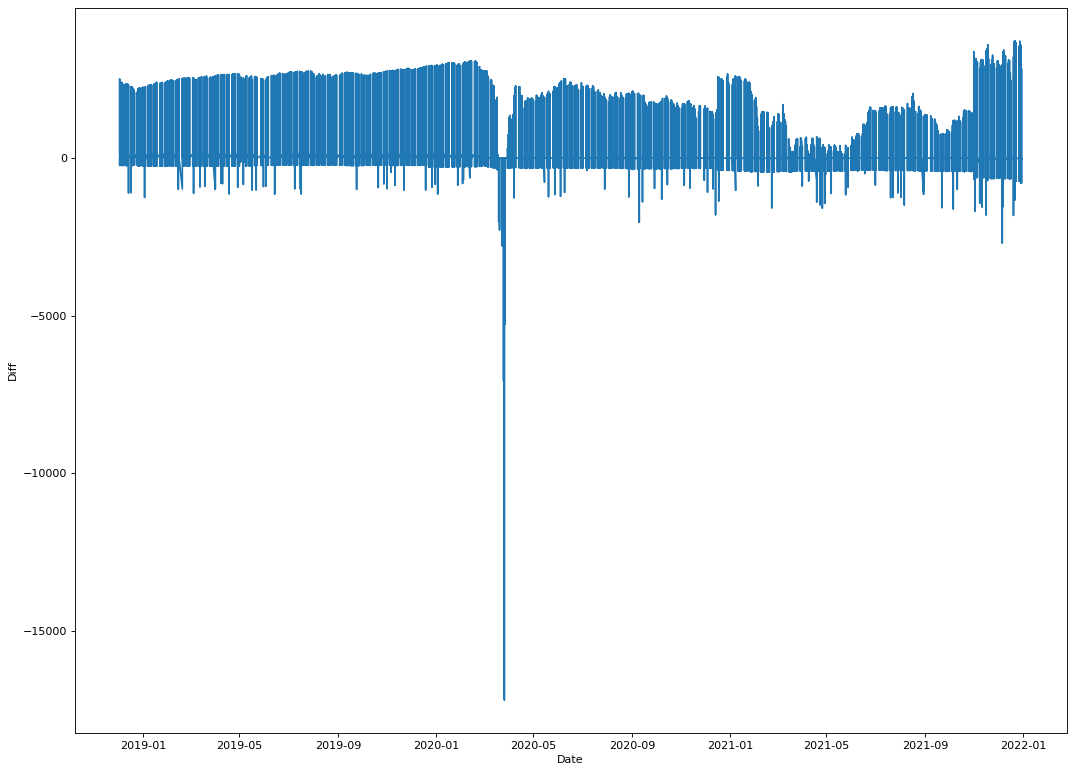

In [53]:
#(df_enhanced[' [QUOTE_DATE]']-df_enhanced['Price']).plot()
matplotlib.pyplot.figure(figsize=(16, 12), dpi=80)
matplotlib.pyplot.plot(df_enhanced[' [QUOTE_DATE]'], (df_enhanced['Black_Scholes']-df_enhanced['Price']))
matplotlib.pyplot.xlabel('Date')
matplotlib.pyplot.ylabel('Diff')
matplotlib.pyplot.show()

In [77]:
(df_enhanced['Black_Scholes']-df_enhanced['Price']).value_counts(sort=False, bins=10)

(-17218.911, -15106.272]         15
(-15106.272, -13014.551]         13
(-13014.551, -10922.829]         12
(-10922.829, -8831.108]           8
(-8831.108, -6739.387]            6
(-6739.387, -4647.666]           42
(-4647.666, -2555.945]           86
(-2555.945, -464.224]          1567
(-464.224, 1627.498]        2024565
(1627.498, 3719.219]         107142
dtype: int64

In [106]:
less_than_10_diff = (df_enhanced['Black_Scholes'] - df_enhanced['Price']).loc[lambda x : (x<=1) & (x>=-1)] #.loc[lambda x : x>=-10]
print(less_than_10_diff.shape[0]/df_enhanced.shape[0]) #this represents the accuracy, with an error bound of $1

0.05374574190886762


In [102]:
less_than_10_diff.shape[0]

115034

87


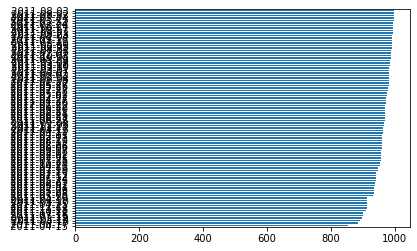

In [ ]:
less_than_1000_transactions = df[' [QUOTE_DATE]'].value_counts(ascending=True).loc[lambda x : x<1000]
print(less_than_1000_transactions.shape[0])
df[' [QUOTE_DATE]'].value_counts(ascending=True)[:less_than_1000_transactions.shape[0]].plot(kind='barh')

BLACK-SCHOLES

Good reference link to Black Scholes Model: https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

In [ ]:
dat = pd.read_csv('spx_eod_202101.csv', low_memory=False)

dat = dat.rename(columns={' [UNDERLYING_LAST]':'SPOT', ' [DTE]':'TIME', ' [C_IV]':'VLTY',
                          ' [STRIKE]':'STRIKE', ' [C_BID]':'BID', ' [C_ASK]':'ASK'})
dat = dat[['SPOT', 'STRIKE', 'TIME', 'VLTY', 'BID', 'ASK']]

ParserError: ignored